<a href="https://colab.research.google.com/github/Zilch123/Aruco-3D-position-Validation/blob/main/ArucoValidation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !pip install opencv-contrib-python
# !git clone https://github.com/ddelago/Aruco-Marker-Calibration-and-Pose-Estimation.git

In [2]:
import os
import sys
import pickle
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cv2.aruco as aruco


Type in your drive path to Data, path is the same till MyDrive

In [3]:
cd drive/MyDrive/Aruco\ CMC\ project/Data/

/content/drive/.shortcut-targets-by-id/1bOHe3Wct63zxzPGjAqK-HttE3BVPIieY/Data


In [7]:
ls Subject\ 1/Subject\ 1/Sub\ 1\ SB

color.pickle  subject1.avi              subject1_color.avi  subject1_depth.avi
prm.pickle    subject1_color_aruco.avi  subject1_color.mp4  xyz.pickle


In [5]:
with open("rotMat_new.pickle",'rb') as f:
    RotMatrix = []
    while True:
        try:
            RotMatrix.append(pickle.load(f))
        except EOFError:
            break

In [6]:
# https://github.com/ddelago/Aruco-Marker-Calibration-and-Pose-Estimation
# Load the Github camera calib profile 
f = open("Aruco-Marker-Calibration-and-Pose-Estimation/calibration/CameraCalibration.pckl", 'rb')
(cameraMatrix, distCoeffs, _, _) = pickle.load(f, encoding='latin1')
f.close()
# Constant parameters used in Aruco methods
ARUCO_PARAMETERS = aruco.DetectorParameters_create()
ARUCO_DICT = aruco.Dictionary_get(aruco.DICT_5X5_50)
# Create grid board object we're using in our stream
board = aruco.GridBoard_create(
        markersX=1,
        markersY=1,
        markerLength=0.09,
        markerSeparation=0.01,
        dictionary=ARUCO_DICT)
# Create vectors we'll be using for rotations and translations for postures
rotation_vectors, translation_vectors = None, None
axis = np.float32([[-.5,-.5,0], [-.5,.5,0], [.5,.5,0], [.5,-.5,0],
                   [-.5,-.5,1],[-.5,.5,1],[.5,.5,1],[.5,-.5,1] ])

# https://stackoverflow.com/questions/46363618/aruco-markers-with-opencv-get-the-3d-corner-coordinates?rq=1
def rotate_marker_corners(rvec, markersize, tvec = None):

    mhalf = markersize / 2.0
    # convert rot vector to rot matrix both do: markerworld -> cam-world
    mrv, jacobian = cv2.Rodrigues(rvec)

    #in markerworld the corners are all in the xy-plane so z is zero at first
    X = mhalf * mrv[:,0] #rotate the x = mhalf
    Y = mhalf * mrv[:,1] #rotate the y = mhalf
    minusX = X * (-1)
    minusY = Y * (-1)

    # calculate 4 corners of the marker in camworld. corners are enumerated clockwise
    markercorners = []
    markercorners.append(np.add(minusX, Y)) #was upper left in markerworld
    markercorners.append(np.add(X, Y)) #was upper right in markerworld
    markercorners.append(np.add( X, minusY)) #was lower right in markerworld
    markercorners.append(np.add(minusX, minusY)) #was lower left in markerworld
    # if tvec given, move all by tvec
    if tvec is not None:
        C = tvec #center of marker in camworld
        for i, mc in enumerate(markercorners):
            markercorners[i] = np.add(C,mc) #add tvec to each corner
    #print('Vec X, Y, C, dot(X,Y)', X,Y,C, np.dot(X,Y)) # just for debug
    markercorners = np.array(markercorners,dtype=np.float32) # type needed when used as input to cv2
    return markercorners, mrv

In [15]:
for subject_number in range(1,2):
  hand_position=pd.DataFrame(columns=['kx', 'ky', 'kz', 'ax', 'ay', 'az' ])
  (height, width, layers) = (368,432,3)
  fps=15.0
  fourcc = cv2.VideoWriter_fourcc(*'MP42')
  video = cv2.VideoWriter("Subject "+str(subject_number)+"/Subject "+str(subjeumber)+"/Sub "+str(subjectct_n_number)+" SB/subject"+str(subject_number)+"_color_aruco.avi", fourcc, float(fps), (width, height))
  # video = cv2.VideoWriter("'drive'/'MyDrive'/'Aruco CMC project'/'subject1.mp4'", fourcc, float(fps), (width, height))
  i=0
  with open("Subject "+str(subject_number)+"/Subject "+str(subject_number)+"/Sub "+str(subject_number)+" SB/color.pickle",'rb') as color_img, \
       open("Subject "+str(subject_number)+"/Subject "+str(subject_number)+"/Sub "+str(subject_number)+" SB/xyz.pickle",'rb') as depth_img:
      while True:
          try:
            # Change RGB to BGR
            color_image = pickle.load(color_img)
            Depth_xyz = pickle.load(depth_img)

            gray = cv2.cvtColor(color_image, cv2.COLOR_BGR2GRAY)

            # Detect Aruco markers
            corners, ids, rejectedImgPoints = aruco.detectMarkers(gray, ARUCO_DICT, parameters=ARUCO_PARAMETERS)
            # Refine detected markers
            # Eliminates markers not part of our board, adds missing markers to the board
            corners, ids, rejectedImgPoints, recoveredIds = aruco.refineDetectedMarkers(
                image = gray,
                board = board,
                detectedCorners = corners,
                detectedIds = ids,
                rejectedCorners = rejectedImgPoints,
                cameraMatrix = cameraMatrix,
                distCoeffs = distCoeffs)   
            ProjectImage = aruco.drawDetectedMarkers(color_image, corners, borderColor=(0, 0, 255))
            if ids is not None and len(ids) > 0:
              # Estimate the posture per each Aruco marker
              rotation_vectors, translation_vectors, _objPoints = aruco.estimatePoseSingleMarkers(corners, 1, cameraMatrix, distCoeffs)

              markerCorner = np.array((corners)).reshape((4, 2))
              (topLeft, topRight, bottomRight, bottomLeft) = markerCorner

              # convert each of the (x, y)-coordinate pairs to integers
              topRight = (int(topRight[0]), int(topRight[1]))
              bottomRight = (int(bottomRight[0]), int(bottomRight[1]))
              bottomLeft = (int(bottomLeft[0]), int(bottomLeft[1]))
              topLeft = (int(topLeft[0]), int(topLeft[1]))

              # draw the bounding box of the ArUCo detection
              cv2.line(ProjectImage, topLeft, topRight, (0, 255, 0), 2)
              cv2.line(ProjectImage, topRight, bottomRight, (0, 255, 0), 2)
              cv2.line(ProjectImage, bottomRight, bottomLeft, (0, 255, 0), 2)
              cv2.line(ProjectImage, bottomLeft, topLeft, (0, 255, 0), 2)

              # compute and draw the center (x, y)-coordinates of the
              # ArUco marker
              cX = int((topLeft[0] + bottomRight[0]) / 2.0)
              cY = int((topLeft[1] + bottomRight[1]) / 2.0)
              cv2.circle(ProjectImage, (cX, cY), 4, (0, 0, 255), -1)

              # 3D Aruco Coordinates 
              markercorners_3d, mrv = rotate_marker_corners(rotation_vectors, markersize =64, tvec = translation_vectors)
              
              markerCorner_xyz = np.array((markercorners_3d)).reshape((4, 3))
              (topLeft, topRight, bottomRight, bottomLeft) = markerCorner_xyz

              # convert each of the (x, y)-coordinate pairs to integers
              topRight = (topRight[0], topRight[1], topRight[2])
              bottomRight = (bottomRight[0], bottomRight[1], bottomRight[2])
              bottomLeft = (bottomLeft[0], bottomLeft[1], bottomLeft[2])
              topLeft = (topLeft[0], topLeft[1], topLeft[2])
              
              # compute  the center (x, y, z)-coordinates of the
              # ArUco marker
              cX_3d = (topLeft[0] + bottomRight[0]) / 2.0
              cY_3d = (topLeft[1] + bottomRight[1]) / 2.0
              cZ_3d = (topLeft[2] + bottomRight[2]) / 2.0

              kinectxyz = Depth_xyz[cY][cX]
              kxyz_axyz = np.append(kinectxyz, translation_vectors)
              hand_position.loc[len(hand_position)] = kxyz_axyz

              # print("mark ", markercorners_)
              # print("\n  ", mrv)
            #   for rvec, tvec in zip(rotation_vectors, translation_vectors):
            #       if len(sys.argv) == 2 and sys.argv[1] == 'cube':
            #           try:
            #               imgpts, jac = cv2.projectPoints(axis, rvec, tvec, cameraMatrix, distCoeffs)
            #               # ProjectImage = drawCube(ProjectImage, corners, imgpts)
            #           except:
            #               continue
            #       else:    
            #         pass
            #           # ProjectImage = aruco.drawAxis(ProjectImage, cameraMatrix, distCoeffs, rvec, tvec, 1)
            # # cv2.imshow('ProjectImage', ProjectImage)

            video.write(cv2.cvtColor(ProjectImage, cv2.COLOR_RGB2BGR))
            i = i+1
          except EOFError:
              break
  video.release()

In [16]:
hand_position.head()

,kx,ky,kz,ax,ay,az
0,-35.0,-86.0,1305.0,-32.613299,-13.996402,65.679007
1,-35.0,-86.0,1307.0,-32.613299,-13.996402,65.679007
2,-35.0,-86.0,1310.0,-32.613299,-13.996402,65.679007
3,-35.0,-86.0,1306.0,-32.613299,-13.996402,65.679007
4,-35.0,-86.0,1307.0,-32.613299,-13.996402,65.679007


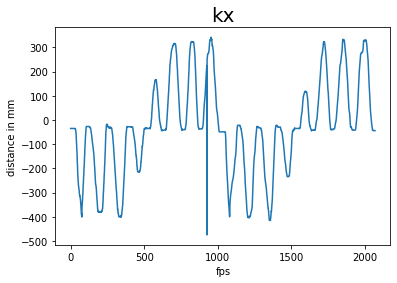

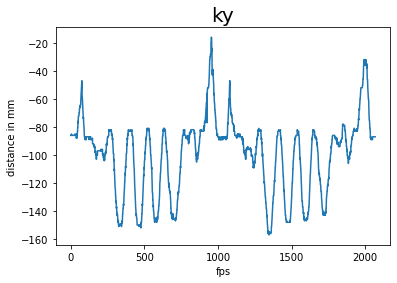

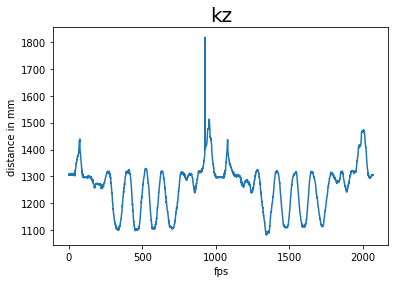

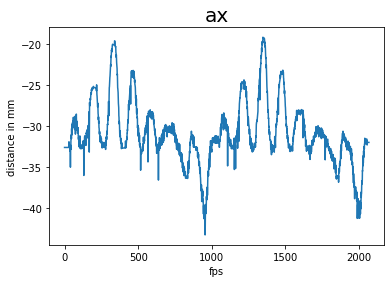

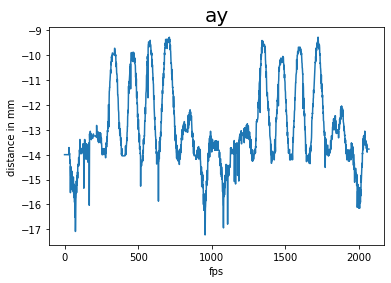

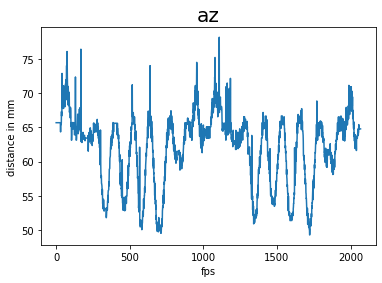

In [17]:
label = ['kx', 'ky', 'kz', 'ax', 'ay', 'az']
for pos in label:
  plt.plot(hand_position[pos])
  plt.xlabel('fps')
  plt.ylabel('distance in mm')
  plt.title(pos, fontsize=20)
  plt.show()

In [ ]:
print(translation_vectors)

None


In [ ]:
def read_calib(RotMatrix):
    return np.matrix(RotMatrix[0:1]), np.matrix(RotMatrix[1:4]).T

def kinect2Local(orig,R_T,kinect_joint):
    Local_co = [np.matmul(R_T.T,(x-orig).T) for x in kinect_joint]
    return(np.array(Local_co).squeeze())

def mocap2kinect(orig,R_T,mocap_joint):
    Local_co = [np.matmul(R_T,(x-orig).T) for x in mocap_joint]
    return(np.array(Local_co).squeeze())

array([[Timestamp('2021-07-03 13:06:40.174130'), nan],
       [Timestamp('2021-07-03 13:06:40.241936'), 0.067806],
       [Timestamp('2021-07-03 13:06:40.311387'), 0.069451],
       ...,
       [Timestamp('2021-07-03 13:09:02.521842'), 0.061488],
       [Timestamp('2021-07-03 13:09:02.586320'), 0.06447800000000001],
       [Timestamp('2021-07-03 13:09:02.660224'), 0.07390400000000001]],
      dtype=object)

In [ ]:
ls Subject\ 1/Subject\ 1

'Sub 1 MC.csv'  'Sub 1 SB'/


In [ ]:
for video_no in range(1,4):
  with open("Subject "+str(video_no)+"/Subject "+str(video_no)+"/Sub "+str(video_no)+" MC.csv") as Mocap_data:
      df_sub1_mocap = pd.read_csv(Mocap_data)
      print(df_sub1_mocap.columns[11])

2021-07-03 01.06.38.066 PM
2021-07-03 01.13.36.002 PM
2021-07-03 01.22.32.226 PM


In [ ]:
print(videos_time_stamp[1][0])
print(videos_time_stamp[2][0])
print(videos_time_stamp[3][0])

[Timestamp('2021-07-03 13:06:40.174130') nan]
[Timestamp('2021-07-03 13:13:38.363945') nan]
[Timestamp('2021-07-03 13:22:34.068252') nan]


In [ ]:
videos_time_stamp={}
for video_no in range(1,4):
  videos_time_stamp_temp = pd.DataFrame()
  t=[]
  with open("Subject "+str(video_no)+"/Subject "+str(video_no)+"/Sub "+str(video_no)+" SB/prm.pickle",'rb') as prm:
      while True:
          try:
              t.append(pickle.load(prm))
          except EOFError:
              videos_time_stamp_temp['time'+str(video_no)] = pd.to_datetime(t)
              videos_time_stamp_temp['time_diff'+str(video_no)] = videos_time_stamp_temp['time'+str(video_no)].diff().dt.total_seconds()
              print(1/videos_time_stamp_temp['time'+str(video_no)].diff().dt.total_seconds().mean())
              videos_time_stamp[video_no] = videos_time_stamp_temp.to_numpy()
              break

14.98391836048221
14.842436313697087
14.95054272665118


0.06673821733021096

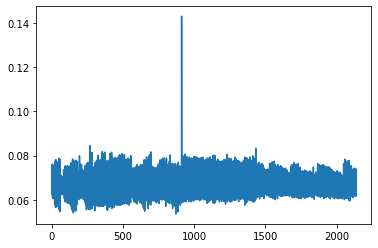

In [ ]:
plt.plot(time_sub1['Delta'].dt.total_seconds())
time_sub1['Delta'].dt.total_seconds().mean()

In [ ]:
framecount_of_videos = [2136, 1158, 1840]
(height, width, layers) = (368,432,3)
Depth_videos = {}
for video_no in range(2,3):
  Depth_xyz = np.empty((framecount_of_videos[video_no-1], height, width, layers))

  with open("Subject "+str(video_no)+"/Subject "+str(video_no)+"/Sub "+str(video_no)+" SB/xyz.pickle",'rb') as depthimg:
      i = 0
      while True:
          try:
              Depth_xyz[i] = pickle.load(depthimg)
              i = i+1
          except EOFError:
              Depth_videos[video_no] = Depth_xyz
              break

[array([-0.141, -0.251,  1.404]),
 array([[ 0.99871538, -0.02327689, -0.023868  ],
        [-0.00993747, -0.95835113, -0.27631295],
        [ 0.04968733,  0.27619518, -0.96077129]])]

In [ ]:
(height, width, layers) = (368,432,3)
fps=15.0
fourcc = cv2.VideoWriter_fourcc(*'MP42')
video = cv2.VideoWriter("Subject 3/Subject 3/Sub 3 SB/subject3_color.avi", fourcc, float(fps), (width, height))
# video = cv2.VideoWriter("'drive'/'MyDrive'/'Aruco CMC project'/'subject1.mp4'", fourcc, float(fps), (width, height))
i=0
with open("Subject 3/Subject 3/Sub 3 SB/color.pickle",'rb') as img:
    while True:
        try:
          # Change RGB to BGR
          video.write(cv2.cvtColor(pickle.load(img), cv2.COLOR_RGB2BGR))
          i = i+1
        except EOFError:
            break
video.release()

In [ ]:
# !ffmpeg -y -loglevel info -i subject3_color.avi subject3_color.mp4